In [1]:
# Define functions to reuse

import os, json

# Flatten the input face detection json to a single-level dictionary.
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                # dataset specific change
                if (a == "position"):
                    flatten(x[a], name + x['type'] + '_')
                else:
                    flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

# Calculate the area of a polygon, given the corner vertices.
def polygon_area(corners):
    n = len(corners)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

In [2]:
# Module to load json files representing facial features of two persons, 
# flatten them and load to pandas dataframe.
# In the output, all features faceAnnotations_0_* corresponds to person 1
# and faceAnnotations_1_* corresponds to person 2.

import os, json
import pandas as pd
from PIL import Image

# Specify the directories to load the interaction and non-interaction dataset
baseDir = '<<Path>>'
interactionDir = baseDir + 'InteractingImages/stage2/'
nonInteractionDir = baseDir + 'NonInteractingImages/stage2/'
datasetsDir = [interactionDir + 'talking/', interactionDir + 'talking2/', interactionDir + 'handshake/', nonInteractionDir + 'ignoring/', nonInteractionDir + 'nottalking/']
listOfFiles = [(datasetDir, os.listdir(datasetDir)) for datasetDir in datasetsDir]
jsonFiles = [datasetDir + file for (datasetDir, fileslist) in listOfFiles for file in fileslist if file.endswith('.json')]

jsonList = []

# Load the json files, flatten them and load to pandas dataframe
for index, js in enumerate(jsonFiles):
    with open(js) as jsonFile:
        jsonObj = json.load(jsonFile)
        
        jsonFlat = flatten_json(jsonObj)
        jsonFlat['localurl'] = js
        imgUrl = js[:-5]
        with Image.open(imgUrl) as img:
            jsonFlat['imgSize'] = img.size
        jsonList.append(jsonFlat)
                        
featuresDf = pd.DataFrame(jsonList)

print("DataFrame Columns : \n")
print(featuresDf.columns.values)


DataFrame Columns : 

['faceAnnotations_0_angerLikelihood' 'faceAnnotations_0_blurredLikelihood'
 'faceAnnotations_0_boundingPoly_vertices_0_x'
 'faceAnnotations_0_boundingPoly_vertices_0_y'
 'faceAnnotations_0_boundingPoly_vertices_1_x'
 'faceAnnotations_0_boundingPoly_vertices_1_y'
 'faceAnnotations_0_boundingPoly_vertices_2_x'
 'faceAnnotations_0_boundingPoly_vertices_2_y'
 'faceAnnotations_0_boundingPoly_vertices_3_x'
 'faceAnnotations_0_boundingPoly_vertices_3_y'
 'faceAnnotations_0_detectionConfidence'
 'faceAnnotations_0_fdBoundingPoly_vertices_0_x'
 'faceAnnotations_0_fdBoundingPoly_vertices_0_y'
 'faceAnnotations_0_fdBoundingPoly_vertices_1_x'
 'faceAnnotations_0_fdBoundingPoly_vertices_1_y'
 'faceAnnotations_0_fdBoundingPoly_vertices_2_x'
 'faceAnnotations_0_fdBoundingPoly_vertices_2_y'
 'faceAnnotations_0_fdBoundingPoly_vertices_3_x'
 'faceAnnotations_0_fdBoundingPoly_vertices_3_y'
 'faceAnnotations_0_headwearLikelihood' 'faceAnnotations_0_joyLikelihood'
 'faceAnnotations_0_

In [3]:
# Module to transform the raw two-person facial features dataframe into a 
# relationship dataframe after normalizing *PolysRelativeArea and *DistImgRatio features.
# Note: panAnglesDiff is normalized later.

# Relationship dataframe columns :
# [
#     'boundingPolysRelativeArea',
#     'fdBoundingPolysRelativeArea',
#     'bpolyDistImgRatio',
#     'fdpolyDistImgRatio',
#     'facesGrid',
#     'facesGridHor',
#     'facesGridVer',
#     'panAnglesDiff',
#     'isInteracting'   
# ]

from collections import defaultdict
import math
import pandas as pd

reldf = pd.DataFrame(columns=['boundingPolysRelativeArea',
                           'fdBoundingPolysRelativeArea',
                           'bpolyDistImgRatio',
                           'fdpolyDistImgRatio',
                           'facesGrid',
                           'facesGridHor',
                           'facesGridVer',
                           'panAnglesDiff',
                           'isInteracting'   
                          ])

for index, row in featuresDf.iterrows():  
    relrow = []
    # print(row['localurl'])
    imgSize = row['imgSize']
    
    if row['localurl'].find("NonInteractingImages") == -1 :
        isInteracting = 1
    else:
        isInteracting = 0
    
    # Area map for bpoly and fdpoly, with 0,1 indices pointing to face1 and face2 
    bpolysMap = defaultdict(list)
    # Midpoint map for bpoly and fdpoly, with 0,1 indices pointing to face1 and face2 
    polyMidpointMap = defaultdict(list)
    # Coordinates map for bpoly and fdpoly, with 0,1 indices pointing to face1 and face2 
    coordMap = defaultdict(list)
    for faceIndex in range(0,2):
        bpolysList = []
        for polyKey in ['boundingPoly', 'fdBoundingPoly']:
            bpoly = ''
            coordinates = []
            coordPrefix = 'faceAnnotations_' + str(faceIndex) + '_' + polyKey + '_' + 'vertices_'
            for i in range(0,4):
                xkey = coordPrefix + str(i) + '_x'
                ykey = coordPrefix + str(i) + '_y'
                coordinates.append((row[xkey],-row[ykey]))
                bpoly = bpoly+','+'('+str(row[xkey])+',-'+str(row[ykey])+')'
            
            # print(coordinates)
            coordMap[polyKey].append(coordinates)
            polyMidpointMap[polyKey].append(
                ((coordinates[0][0]+coordinates[2][0])/2,(coordinates[0][1] + coordinates[2][1])/2 ))
            bpolysMap[polyKey].append(polygon_area(coordinates))
            # print(bpoly)
    
    # Finding the relative area of bounding polygons of two faces and Normalizing the ratios
    bpolyRelativeArea = (max(bpolysMap['boundingPoly'])/min(bpolysMap['boundingPoly'])) - 1.0
    fdbpolyRelativeArea = (max(bpolysMap['fdBoundingPoly'])/min(bpolysMap['fdBoundingPoly'])) - 1.0
    
    # Normalizing the ratios
    bpolyRelativeArea = bpolyRelativeArea / 2
    fdbpolyRelativeArea = fdbpolyRelativeArea / 2
    
    if bpolyRelativeArea > 1.0 :
        bpolyRelativeArea = 1.0
    if fdbpolyRelativeArea > 1.0:
        fdbpolyRelativeArea = 1.0
    
    relrow.append(bpolyRelativeArea)
    relrow.append(fdbpolyRelativeArea)
    
    # Finding the ratio of distance between two faces and the image diagonal length
    bpolyDist = math.hypot(polyMidpointMap['boundingPoly'][1][0] - polyMidpointMap['boundingPoly'][0][0], 
                     polyMidpointMap['boundingPoly'][1][1] - polyMidpointMap['boundingPoly'][0][1])
    fdPolyDist = math.hypot(polyMidpointMap['fdBoundingPoly'][1][0] - polyMidpointMap['fdBoundingPoly'][0][0], 
                     polyMidpointMap['fdBoundingPoly'][1][1] - polyMidpointMap['fdBoundingPoly'][0][1])
    imageDiagLen = math.hypot(imgSize[1], imgSize[0])
    bpolyDistImgRatio = bpolyDist/imageDiagLen
    fdpolyDistImgRatio = fdPolyDist/imageDiagLen
    
    relrow.append(bpolyDistImgRatio)
    relrow.append(fdpolyDistImgRatio)
    
    # Finding the position of fdpoly indside bpoly for both the faces
    # the list will have two indices each representing two faces
    ldists = []
    rdists = []
    tdists = []
    bdists = []
    
    leftmostface = 0
    if(coordMap['boundingPoly'][1][0][0] < coordMap['boundingPoly'][0][0][0]):
        leftmostface = 1
    
    for faceIndex in range(0,2):
        bpolyCoords = coordMap['boundingPoly'][faceIndex]
        fdpolyCoords = coordMap['fdBoundingPoly'][faceIndex]
        
        # b:x1 - fd:x1
        ldists.append(bpolyCoords[0][0] - fdpolyCoords[0][0])
        # b:x2 - fd:x2
        rdists.append(bpolyCoords[1][0] - fdpolyCoords[1][0])
        # b:y1 - fd:y1
        tdists.append(bpolyCoords[0][1] - fdpolyCoords[0][1])
        # b:y3 - fd:y3
        bdists.append(bpolyCoords[2][1] - fdpolyCoords[2][1])

    # the list will have two indices each representing two faces
    facesGridHor = []
    facesGridVer = []
    
    for faceIndex in range(0,2):
    
        faceGridHor = ''
        faceGridVer = ''

        if(tdists[faceIndex] <= 0):
            faceGridHor += 'T'
        elif (bdists[faceIndex] >= 0):
            faceGridHor += 'B'
        else:
            tdistabs = abs(tdists[faceIndex])
            bdistabs = abs(bdists[faceIndex])
            if((max(tdistabs,bdistabs)/min(tdistabs,bdistabs)) > 1.2):
                if tdistabs > bdistabs :
                    faceGridHor += 'B'
                else :
                    faceGridHor += 'T'
            else:
                faceGridHor += 'M'

        if(ldists[faceIndex] >= 0):
            faceGridVer += 'L'
        elif (rdists[faceIndex] <= 0):
            faceGridVer += 'R'
        else:
            ldistabs = abs(ldists[faceIndex])
            rdistabs = abs(rdists[faceIndex])
            if((max(ldistabs,rdistabs)/min(ldistabs,rdistabs)) > 1.2):
                if ldistabs > rdistabs :
                    faceGridVer += 'R'
                else:
                    faceGridVer += 'L'
            else:
                faceGridVer += 'C'
            
        facesGridHor.append(faceGridHor)
        facesGridVer.append(faceGridVer)
       
    facesGridStr = facesGridHor[0] + facesGridVer[0] + facesGridHor[1] + facesGridVer[1]
    facesGridHorStr = facesGridHor[0] + facesGridHor[1]
    facesGridVerStr = facesGridVer[0] + facesGridVer[1]
    if leftmostface == 1:
        facesGridStr = facesGridHor[1] + facesGridVer[1] + facesGridHor[0] + facesGridVer[0]
        facesGridHorStr = facesGridHor[1] + facesGridHor[0]
        facesGridVerStr = facesGridVer[1] + facesGridVer[0]
        
    relrow.append(facesGridStr)
    relrow.append(facesGridHorStr)
    relrow.append(facesGridVerStr)

    # Finding the relation between pan angles and tilt angles
    panAngles = []
    tiltAngles = []
    for faceIndex in range(0,2):
        panAngles.append(row['faceAnnotations_' + str(faceIndex) + '_panAngle'])
        tiltAngles.append(row['faceAnnotations_' + str(faceIndex) + '_tiltAngle'])
    
    if(leftmostface == 1):
        panDiff = (90 - panAngles[1]) + (panAngles[0] - 90*-1)
        tiltDiff = tiltAngles[1] + tiltAngles[0]
    else:
        panDiff = (90 - panAngles[0]) + (panAngles[1] - 90*-1)
        tiltDiff = tiltAngles[0] + tiltAngles[1]
    
    relrow.append(panDiff)
    relrow.append(isInteracting)
    reldf.loc[len(reldf)] = relrow
    
reldf


,boundingPolysRelativeArea,fdBoundingPolysRelativeArea,bpolyDistImgRatio,fdpolyDistImgRatio,facesGrid,facesGridHor,facesGridVer,panAnglesDiff,isInteracting
0,0.177966,0.030400,0.218581,0.207274,BLBL,BB,LL,114.896601,1
1,0.155369,0.189846,0.305924,0.273171,BRBL,BB,RL,56.257923,1
2,0.076664,0.046467,0.297395,0.284656,BRBL,BB,RL,62.539864,1
3,0.000000,0.275927,NaN,0.217702,MRBC,MB,RC,152.018205,1
4,0.000000,0.139747,NaN,0.350340,BLBC,BB,LC,288.649712,1
5,0.091461,0.140950,0.338170,0.307593,BRBL,BB,RL,104.267973,1
6,0.006757,0.040800,0.438897,0.431091,BRBL,BB,RL,66.453926,1
7,0.087774,0.290748,0.321282,0.291409,BRBL,BB,RL,48.138496,1
8,0.045190,0.135047,0.202458,0.183111,BRBL,BB,RL,93.283873,1
9,0.029090,0.017857,0.261977,0.224534,BRBL,BB,RL,58.174877,1


In [4]:
# Dropping rows with insufficient data
reldf.dropna(inplace=True)
reldf

,boundingPolysRelativeArea,fdBoundingPolysRelativeArea,bpolyDistImgRatio,fdpolyDistImgRatio,facesGrid,facesGridHor,facesGridVer,panAnglesDiff,isInteracting
0,0.177966,0.030400,0.218581,0.207274,BLBL,BB,LL,114.896601,1
1,0.155369,0.189846,0.305924,0.273171,BRBL,BB,RL,56.257923,1
2,0.076664,0.046467,0.297395,0.284656,BRBL,BB,RL,62.539864,1
5,0.091461,0.140950,0.338170,0.307593,BRBL,BB,RL,104.267973,1
6,0.006757,0.040800,0.438897,0.431091,BRBL,BB,RL,66.453926,1
7,0.087774,0.290748,0.321282,0.291409,BRBL,BB,RL,48.138496,1
8,0.045190,0.135047,0.202458,0.183111,BRBL,BB,RL,93.283873,1
9,0.029090,0.017857,0.261977,0.224534,BRBL,BB,RL,58.174877,1
10,0.136985,0.156033,0.252696,0.251183,BLBL,BB,LL,163.319244,1
11,0.076662,0.055926,0.227130,0.205201,BRBL,BB,RL,89.774143,1


In [5]:
# Printing stats for interacting dataset
reldf[reldf['isInteracting'] == 1].describe()

,boundingPolysRelativeArea,fdBoundingPolysRelativeArea,bpolyDistImgRatio,fdpolyDistImgRatio,panAnglesDiff
count,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.124084,0.111915,0.329211,0.306966,81.746843
std,0.148286,0.130155,0.097978,0.097045,47.787366
min,0.000000,0.000000,0.079677,0.075205,-6.335106
25%,0.030909,0.031033,0.268567,0.244902,47.886358
50%,0.081073,0.073484,0.323329,0.301177,69.360804
75%,0.155547,0.145645,0.384968,0.359975,112.551279
max,1.000000,0.963709,0.627477,0.608953,354.234711


In [6]:
# Printing stats for non interacting dataset
reldf[reldf['isInteracting'] == 0].describe()

,boundingPolysRelativeArea,fdBoundingPolysRelativeArea,bpolyDistImgRatio,fdpolyDistImgRatio,panAnglesDiff
count,315.000000,315.000000,315.000000,315.000000,315.000000
mean,0.263867,0.246137,0.331270,0.338111,213.946532
std,0.324841,0.308570,0.099618,0.099509,67.686778
min,0.000000,0.000000,0.019390,0.018522,34.110374
25%,0.057157,0.040042,0.258765,0.266758,173.882005
50%,0.116284,0.117284,0.340596,0.342764,216.220690
75%,0.297599,0.320140,0.399986,0.412290,260.926501
max,1.000000,1.000000,0.639489,0.604577,364.953300


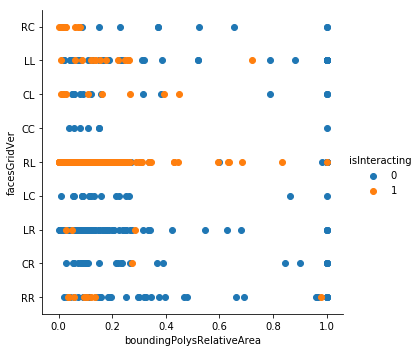

In [8]:
# Plotting boundingPolysRelativeArea against facesGridVer

# Displays the grid value RL strongly favors interacting images
# and LR favoring non-interacting images.
# Also it is seen that with increase in boundingpolys area ratio, 
# data points are inclined to non-interacting and otherwise for interacting.

import seaborn as sns
import matplotlib.pyplot as plt 

sns.FacetGrid(reldf, 
    hue="isInteracting", height=5, aspect=1).map(plt.scatter, "boundingPolysRelativeArea", "facesGridVer").add_legend()

plt.show()

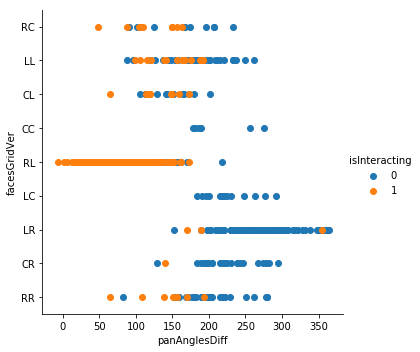

In [9]:
# Plotting panAnglesDiff vs facesGridVer

# Depicting that panAnglesDiff in range 0-180 correspond to interacting and 180-360 to be non-interating
# Also it captures the GRID values distribution against the pan angles. 

sns.FacetGrid(reldf, 
    hue="isInteracting", height=5, aspect=1).map(plt.scatter, "panAnglesDiff", "facesGridVer").add_legend()

plt.show()

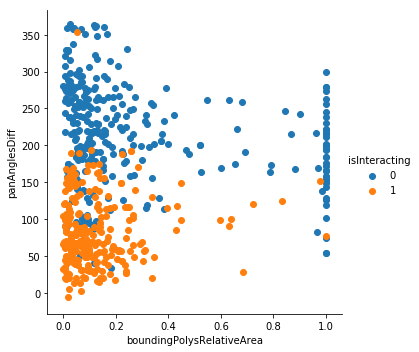

In [10]:
# Plotting panAnglesDiff vs boundingPolysRelativeArea

sns.FacetGrid(reldf, 
    hue="isInteracting", height=5, aspect=1).map(plt.scatter, "boundingPolysRelativeArea", "panAnglesDiff").add_legend()

plt.show()

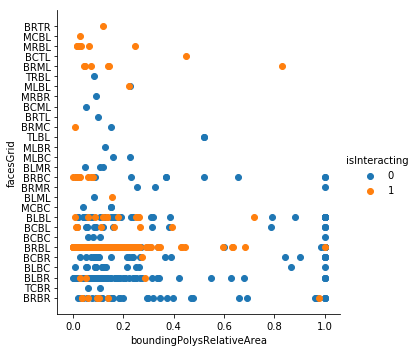

In [11]:
# Plotting facesGrid vs boundingPolysRelativeArea

sns.FacetGrid(reldf, 
    hue="isInteracting", height=5, aspect=1).map(plt.scatter, "boundingPolysRelativeArea", "facesGrid").add_legend()

plt.show()

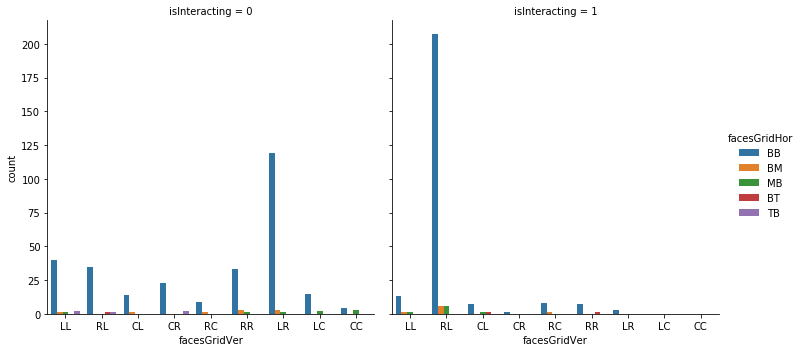

In [12]:
# Plotting facesGridHor vs facesGridVer

sns.catplot(x="facesGridVer", hue="facesGridHor", col="isInteracting",data=reldf, kind="count",height=5, aspect=1);

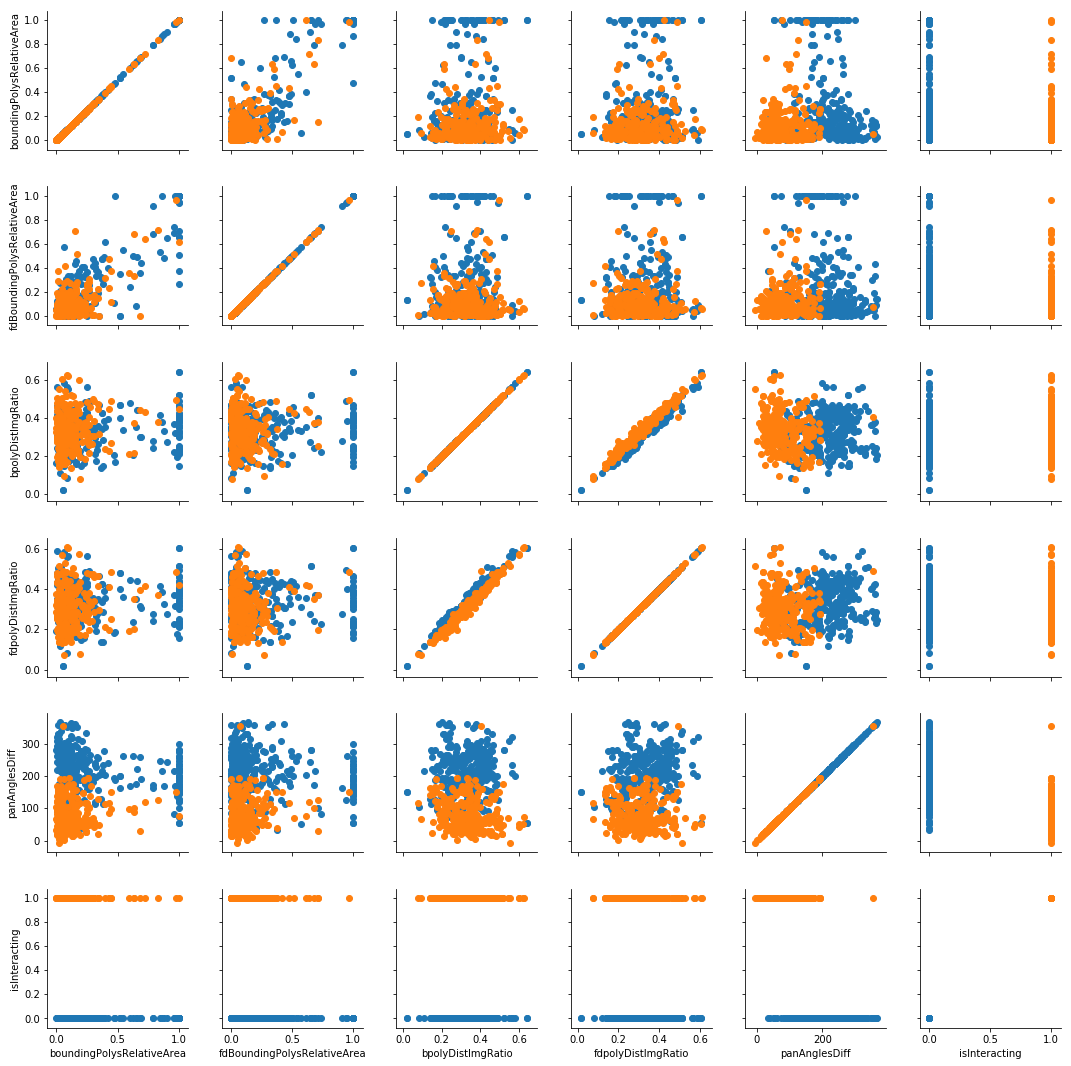

In [13]:
# Plotting all non-discrete data against each other

g = sns.PairGrid(reldf, hue="isInteracting")
g.map(plt.scatter);

In [14]:
# Module to define the different classifiers to be used for classification

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Function to get classifier based on classifier key and optional params for different classifiers.
def get_classifier(classifier, 
                   knn_n=3, 
                   knn_weights='uniform', 
                   svm_kernel='linear', 
                   dtree_criterion='gini',
                   dtree_max_depth=None,
                   dtree_min_samples_leaf=1,
                   dtree_splitter='best'
                   ) :
    if classifier == 'dtree' :
        return tree.DecisionTreeClassifier(criterion=dtree_criterion, 
                                           max_depth=dtree_max_depth,
                                           min_samples_leaf=dtree_min_samples_leaf,
                                           splitter=dtree_splitter)
    elif classifier == 'knn' :
        return KNeighborsClassifier(n_neighbors=knn_n, weights=knn_weights)
    elif classifier == "svm" :
        return SVC(kernel=svm_kernel, gamma='auto', decision_function_shape='ovr',probability=True)
    raise Exception('No Classifier found')

In [15]:
# Module to iterate several times while splitting data into training and test, train the model, 
# predict the model with test data, generate accuracy scores, confidence data, f-scores, confusion matrix etc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import graphviz 
from IPython.display import Image, display
import time
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


# Function that does random training:test split, train the model, print decision tree, predict the training
# test accuracy scores and print confusion matrix.
def featureScore(mat, label, c_key, 
                       knn_n=3, knn_weights='uniform', 
                       svm_kernel='linear',
                       dtree_criterion='gini',
                       dtree_max_depth=None,
                       dtree_min_samples_leaf=1,
                       dtree_splitter='best'
                       ):
    
    # Containers to hold the training and test data prediction accuracies for multiple runs
    train_accuracy = []
    test_accuracy = []
    f_scores = []
    
    # Running for 10 times with randomized training, test splits.
    for i in range(1,11):
        # test_size=0.21585 splits train:test as 7291:2007
        # random_state=i sets the seed for the shuffle
        x_train, x_test, y_train, y_test = train_test_split(mat, label, test_size=0.21585, random_state=i)
        
        # Flatten and adjust the labels to fit the images (1..10) -> (0..9)
        y_train_flat = [i[0] for i in y_train]
        y_test_flat = [i[0] for i in y_test]
        
        # Get the classifier based on classifier key and input params
        classifier = get_classifier(c_key, 
                                    knn_n=knn_n, 
                                    svm_kernel=svm_kernel, 
                                    knn_weights=knn_weights,
                                    dtree_criterion=dtree_criterion, 
                                    dtree_max_depth=dtree_max_depth,
                                    dtree_min_samples_leaf=dtree_min_samples_leaf,
                                    dtree_splitter=dtree_splitter
                                    )
        
        # Train the classifier
        start_time = time.time()
        classifier = classifier.fit(x_train, y_train_flat)
        elapsed_time = time.time() - start_time
       
        
        # Get the training dataset predictions with default prob threshold being 0.5
        train_pred = classifier.predict(x_train)
        train_accuracy.append((train_pred == y_train_flat).sum()/len(y_train_flat))
        
        # Get the tedt dataset predictions with default prob threshold being 0.5
        test_pred = classifier.predict(x_test)
        test_accuracy.append((test_pred == y_test_flat).sum()/len(y_test_flat))
        # Get the confidence score
        test_predProb = classifier.predict_proba(x_test)
        np.set_printoptions(suppress=True)
        f_scores.append(f1_score(y_test_flat, test_pred, average='weighted'))
            
        # print(classifier)
        
        if i % 5 == 0:
            
            # Get Confidence scores
            confScoreFrame = pd.DataFrame(test_predProb)
            confScoreFrame['Predicted'] = test_pred
        
            print(test_pred.shape)
            print(confScoreFrame)
      
            # Get the confusion matrix
            cm = confusion_matrix(y_test_flat, test_pred, labels=list(range(0, 2)))

            df_cm = pd.DataFrame(cm, index = list(range(0, 2)),
                      columns = list(range(0, 2)))
            plt.figure(figsize = (10,7))
            sn.heatmap(df_cm, annot=True)
        
            print(classification_report(y_test_flat, test_pred, target_names=[i for i in '01']))

    
    return {"trainScr" : np.mean(train_accuracy), 
        "testScr" : np.mean(test_accuracy), 
        "elapsed" : elapsed_time,
        "class" : classifier,
        "f_score" : np.mean(f_scores)}

In [16]:
# Module to do One Hot encoding for discrete features and normalize panangles feature

reldf_oh = pd.get_dummies(data=reldf, columns=['facesGridVer','facesGridHor']) 
reldf_oh = reldf_oh.drop(['facesGrid'], axis=1)
cols = list(reldf_oh.columns.values)
cols.pop(cols.index('isInteracting'))
reldf_oh = reldf_oh[cols+['isInteracting']]
reldf_oh['panAnglesDiff'] = ((reldf_oh['panAnglesDiff']-reldf_oh['panAnglesDiff'].min())/(reldf_oh['panAnglesDiff'].max()-reldf_oh['panAnglesDiff'].min()))*1
datamatrix = reldf_oh.as_matrix()
features = datamatrix[:,0:datamatrix.shape[1]-1]
labels = datamatrix[:,datamatrix.shape[1]-1:]
reldf_oh

/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


,boundingPolysRelativeArea,fdBoundingPolysRelativeArea,bpolyDistImgRatio,fdpolyDistImgRatio,panAnglesDiff,facesGridVer_CC,facesGridVer_CL,facesGridVer_CR,facesGridVer_LC,facesGridVer_LL,facesGridVer_LR,facesGridVer_RC,facesGridVer_RL,facesGridVer_RR,facesGridHor_BB,facesGridHor_BM,facesGridHor_BT,facesGridHor_MB,facesGridHor_TB,isInteracting
0,0.177966,0.030400,0.218581,0.207274,0.326516,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,0.155369,0.189846,0.305924,0.273171,0.168583,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
2,0.076664,0.046467,0.297395,0.284656,0.185503,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
5,0.091461,0.140950,0.338170,0.307593,0.297890,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
6,0.006757,0.040800,0.438897,0.431091,0.196044,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
7,0.087774,0.290748,0.321282,0.291409,0.146715,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
8,0.045190,0.135047,0.202458,0.183111,0.268306,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
9,0.029090,0.017857,0.261977,0.224534,0.173746,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
10,0.136985,0.156033,0.252696,0.251183,0.456934,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
11,0.076662,0.055926,0.227130,0.205201,0.258853,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1


In [17]:
# Printing stats for mormalized relationship dataset of interacting images

reldf_oh[reldf_oh['isInteracting'] == 1].describe()

,boundingPolysRelativeArea,fdBoundingPolysRelativeArea,bpolyDistImgRatio,fdpolyDistImgRatio,panAnglesDiff,facesGridVer_CC,facesGridVer_CL,facesGridVer_CR,facesGridVer_LC,facesGridVer_LL,facesGridVer_LR,facesGridVer_RC,facesGridVer_RL,facesGridVer_RR,facesGridHor_BB,facesGridHor_BM,facesGridHor_BT,facesGridHor_MB,facesGridHor_TB
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.0,264.000000,264.000000,264.0,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.0
mean,0.124084,0.111915,0.329211,0.306966,0.237233,0.0,0.034091,0.003788,0.0,0.056818,0.011364,0.034091,0.829545,0.030303,0.931818,0.030303,0.007576,0.030303,0.0
std,0.148286,0.130155,0.097978,0.097045,0.128707,0.0,0.181807,0.061546,0.0,0.231935,0.106194,0.181807,0.376746,0.171745,0.252536,0.171745,0.086873,0.171745,0.0
min,0.000000,0.000000,0.079677,0.075205,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.030909,0.031033,0.268567,0.244902,0.146036,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
50%,0.081073,0.073484,0.323329,0.301177,0.203874,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
75%,0.155547,0.145645,0.384968,0.359975,0.320200,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,0.963709,0.627477,0.608953,0.971131,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [18]:
# Printing stats for mormalized relationship dataset of non-interacting images

reldf_oh[reldf_oh['isInteracting'] == 0].describe()

,boundingPolysRelativeArea,fdBoundingPolysRelativeArea,bpolyDistImgRatio,fdpolyDistImgRatio,panAnglesDiff,facesGridVer_CC,facesGridVer_CL,facesGridVer_CR,facesGridVer_LC,facesGridVer_LL,facesGridVer_LR,facesGridVer_RC,facesGridVer_RL,facesGridVer_RR,facesGridHor_BB,facesGridHor_BM,facesGridHor_BT,facesGridHor_MB,facesGridHor_TB
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.00000,315.00000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,0.263867,0.246137,0.331270,0.338111,0.593290,0.022222,0.047619,0.079365,0.053968,0.139683,0.390476,0.031746,0.11746,0.11746,0.926984,0.028571,0.003175,0.025397,0.015873
std,0.324841,0.308570,0.099618,0.099509,0.182302,0.147640,0.213298,0.270738,0.226315,0.347209,0.488633,0.175602,0.32248,0.32248,0.260576,0.166864,0.056344,0.157577,0.125183
min,0.000000,0.000000,0.019390,0.018522,0.108933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.057157,0.040042,0.258765,0.266758,0.485383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.116284,0.117284,0.340596,0.342764,0.599415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.297599,0.320140,0.399986,0.412290,0.719822,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.639489,0.604577,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# List to hold the resuts of different classification models

comparison_list= []

(125,)
            0         1  Predicted
0    0.159401  0.840599          1
1    0.918705  0.081295          0
2    0.134760  0.865240          1
3    0.836887  0.163113          0
4    0.117341  0.882659          1
5    0.848243  0.151757          0
6    0.203394  0.796606          1
7    0.680070  0.319930          0
8    0.826635  0.173365          0
9    0.110132  0.889868          1
10   0.810836  0.189164          0
11   0.800067  0.199933          0
12   0.210758  0.789242          1
13   0.903275  0.096725          0
14   0.217165  0.782835          1
15   0.924755  0.075245          0
16   0.913372  0.086628          0
17   0.123286  0.876714          1
18   0.948731  0.051269          0
19   0.904882  0.095118          0
20   0.141542  0.858458          1
21   0.133763  0.866237          1
22   0.439239  0.560761          1
23   0.137297  0.862703          1
24   0.751362  0.248638          0
25   0.897178  0.102822          0
26   0.178851  0.821149          1
27   0.571059

{'trainScr': 0.8731277533039649,
 'testScr': 0.8648,
 'elapsed': 0.024084806442260742,
 'class': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'f_score': 0.8648938158977441}

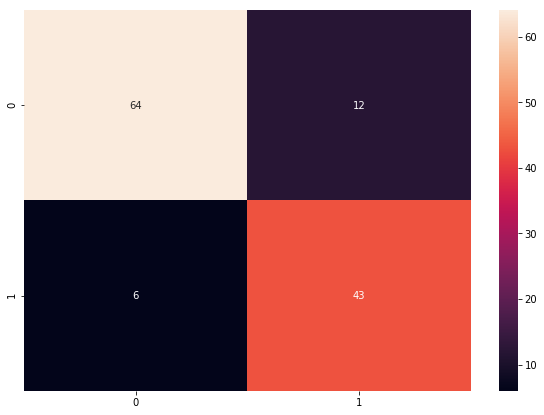

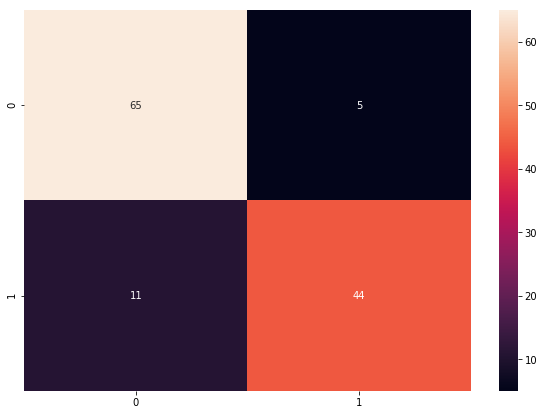

In [20]:
# Running SVM with linear kernel

res = featureScore(features, labels, 'svm', svm_kernel='linear')
comparison_list.append(res)
res

(125,)
            0         1  Predicted
0    0.000000  1.000000          1
1    1.000000  0.000000          0
2    0.000000  1.000000          1
3    0.666667  0.333333          0
4    0.000000  1.000000          1
5    1.000000  0.000000          0
6    0.000000  1.000000          1
7    0.666667  0.333333          0
8    1.000000  0.000000          0
9    0.000000  1.000000          1
10   1.000000  0.000000          0
11   1.000000  0.000000          0
12   0.000000  1.000000          1
13   1.000000  0.000000          0
14   0.000000  1.000000          1
15   1.000000  0.000000          0
16   1.000000  0.000000          0
17   0.000000  1.000000          1
18   1.000000  0.000000          0
19   1.000000  0.000000          0
20   0.333333  0.666667          1
21   0.000000  1.000000          1
22   0.666667  0.333333          0
23   0.000000  1.000000          1
24   1.000000  0.000000          0
25   1.000000  0.000000          0
26   0.000000  1.000000          1
27   0.666667

{'trainScr': 0.9255506607929516,
 'testScr': 0.8560000000000001,
 'elapsed': 0.0011191368103027344,
 'class': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=3, p=2,
            weights='uniform'),
 'f_score': 0.8560176549656837}

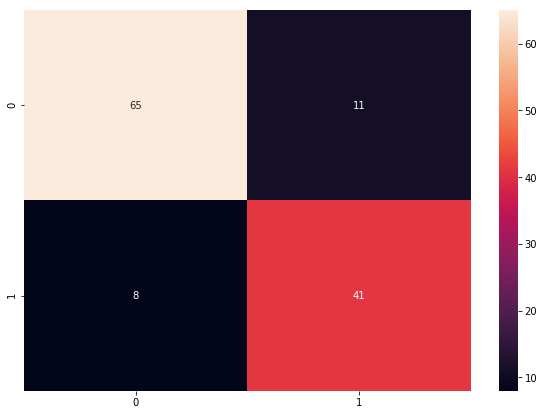

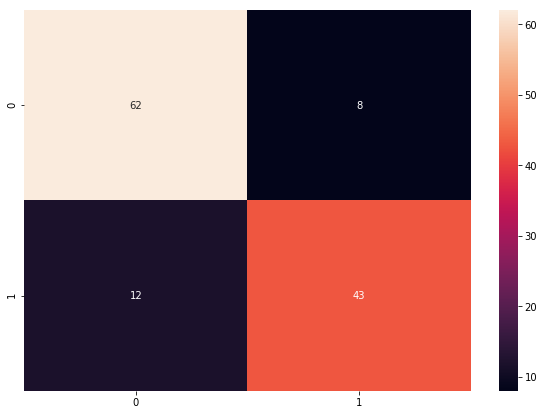

In [21]:
# Running KNN with N=3 and uniform weights

res = featureScore(features, labels, 'knn', knn_n=3, knn_weights='uniform' )
comparison_list.append(res)
res

(125,)
       0    1  Predicted
0    0.0  1.0          1
1    1.0  0.0          0
2    0.0  1.0          1
3    0.5  0.5          0
4    0.0  1.0          1
5    1.0  0.0          0
6    0.0  1.0          1
7    0.5  0.5          0
8    1.0  0.0          0
9    0.0  1.0          1
10   1.0  0.0          0
11   1.0  0.0          0
12   0.0  1.0          1
13   1.0  0.0          0
14   0.0  1.0          1
15   1.0  0.0          0
16   1.0  0.0          0
17   0.0  1.0          1
18   1.0  0.0          0
19   1.0  0.0          0
20   0.0  1.0          1
21   0.0  1.0          1
22   1.0  0.0          0
23   0.0  1.0          1
24   1.0  0.0          0
25   1.0  0.0          0
26   0.0  1.0          1
27   1.0  0.0          0
28   0.0  1.0          1
29   0.5  0.5          0
..   ...  ...        ...
95   0.5  0.5          0
96   1.0  0.0          0
97   1.0  0.0          0
98   0.5  0.5          0
99   1.0  0.0          0
100  0.0  1.0          1
101  0.0  1.0          1
102  1.0  0.0     

{'trainScr': 0.9259911894273127,
 'testScr': 0.8400000000000001,
 'elapsed': 0.0010962486267089844,
 'class': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=2, p=2,
            weights='uniform'),
 'f_score': 0.8381245073536814}

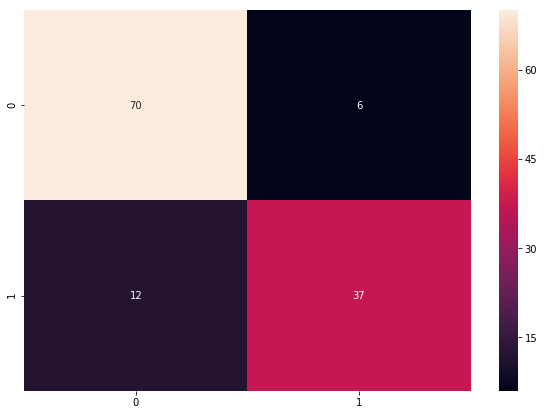

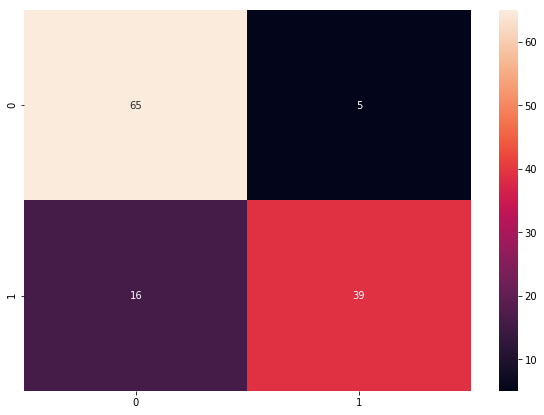

In [22]:
# Running KNN with N=2 and uniform weights

res = featureScore(features, labels, 'knn', knn_n=2, knn_weights='uniform' )
comparison_list.append(res)
res

(125,)
            0         1  Predicted
0    0.000000  1.000000          1
1    1.000000  0.000000          0
2    0.000000  1.000000          1
3    0.621915  0.378085          0
4    0.000000  1.000000          1
5    1.000000  0.000000          0
6    0.000000  1.000000          1
7    0.644276  0.355724          0
8    1.000000  0.000000          0
9    0.000000  1.000000          1
10   1.000000  0.000000          0
11   1.000000  0.000000          0
12   0.000000  1.000000          1
13   1.000000  0.000000          0
14   0.000000  1.000000          1
15   1.000000  0.000000          0
16   1.000000  0.000000          0
17   0.000000  1.000000          1
18   1.000000  0.000000          0
19   1.000000  0.000000          0
20   0.000000  1.000000          1
21   0.000000  1.000000          1
22   0.698025  0.301975          0
23   0.000000  1.000000          1
24   1.000000  0.000000          0
25   1.000000  0.000000          0
26   0.000000  1.000000          1
27   1.000000

{'trainScr': 1.0,
 'testScr': 0.8552000000000002,
 'elapsed': 0.0013010501861572266,
 'class': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=3, p=2,
            weights='distance'),
 'f_score': 0.8553258384127327}

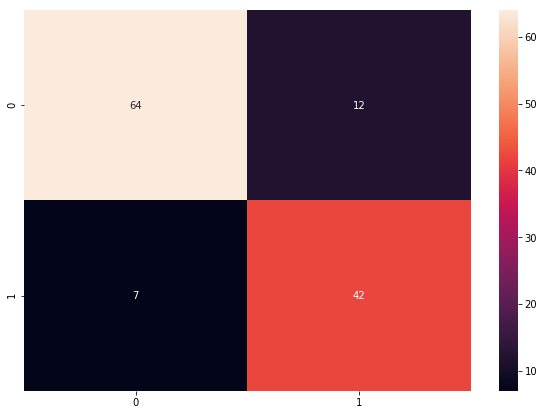

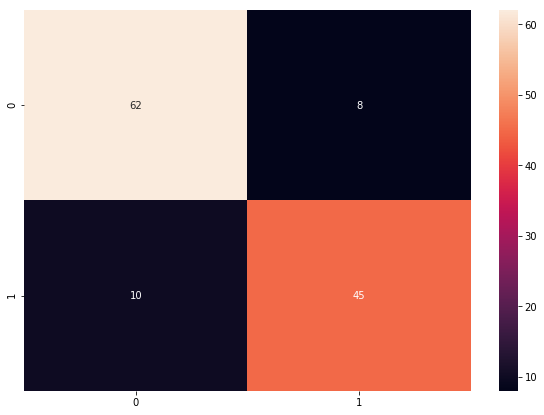

In [23]:
# Running KNN with N=3 and distance weights

res = featureScore(features, labels, 'knn', knn_n=3, knn_weights='distance' )
comparison_list.append(res)
res

(125,)
        0     1  Predicted
0    0.00  1.00          1
1    1.00  0.00          0
2    0.00  1.00          1
3    0.50  0.50          0
4    0.00  1.00          1
5    0.75  0.25          0
6    0.00  1.00          1
7    0.75  0.25          0
8    0.75  0.25          0
9    0.00  1.00          1
10   0.75  0.25          0
11   1.00  0.00          0
12   0.00  1.00          1
13   1.00  0.00          0
14   0.00  1.00          1
15   1.00  0.00          0
16   1.00  0.00          0
17   0.00  1.00          1
18   1.00  0.00          0
19   1.00  0.00          0
20   0.50  0.50          0
21   0.00  1.00          1
22   0.50  0.50          0
23   0.00  1.00          1
24   1.00  0.00          0
25   1.00  0.00          0
26   0.25  0.75          1
27   0.50  0.50          0
28   0.00  1.00          1
29   0.25  0.75          1
..    ...   ...        ...
95   0.50  0.50          0
96   1.00  0.00          0
97   1.00  0.00          0
98   0.75  0.25          0
99   0.75  0.25      

{'trainScr': 0.9083700440528635,
 'testScr': 0.8424000000000001,
 'elapsed': 0.0011010169982910156,
 'class': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=4, p=2,
            weights='uniform'),
 'f_score': 0.8413977386709934}

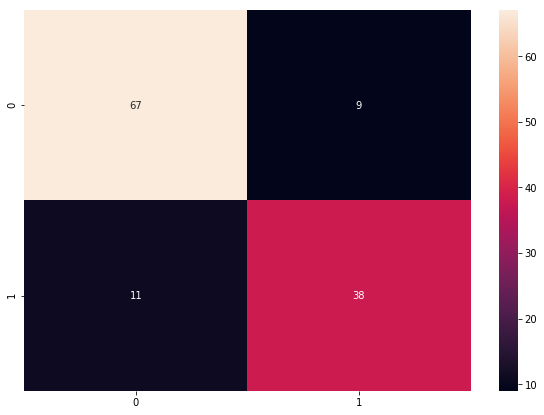

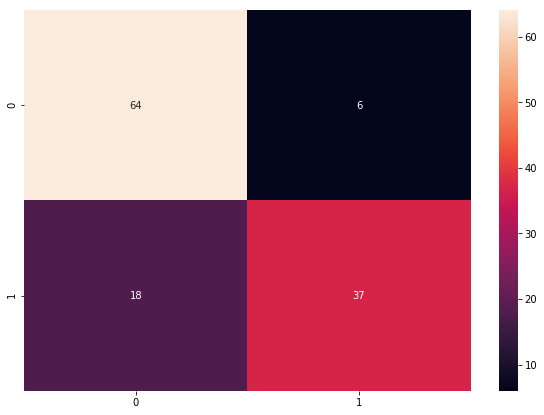

In [24]:
# Running KNN with N=4 and uniform weights

res = featureScore(features, labels, 'knn', knn_n=4, knn_weights='uniform' )
comparison_list.append(res)
res

In [25]:
# Summarizing the classification models performance.

pd.set_option('max_colwidth', 200)
resdf = pd.DataFrame(comparison_list)
resdf[['class', 'trainScr', 'testScr', 'f_score', 'elapsed']]

,class,trainScr,testScr,f_score,elapsed
0,"SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',\n max_iter=-1, probability=True, random_state=None, shrinking=T...",0.873128,0.8648,0.864894,0.024085
1,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=3, p=2,\n weights='uniform')",0.925551,0.8560,0.856018,0.001119
2,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=2, p=2,\n weights='uniform')",0.925991,0.8400,0.838125,0.001096
3,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=3, p=2,\n weights='distance')",1.000000,0.8552,0.855326,0.001301
4,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=4, p=2,\n weights='uniform')",0.908370,0.8424,0.841398,0.001101
